# CAPM and Fama French

In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn

seaborn.set()
plt.rcParams['figure.figsize'] = [9, 7]

In [2]:
# Helper method to change fama french date to pandas date
def create_date(int_date):
    year = int_date // 10000
    month = (int_date // 1000 % 10) * 10 + (int_date // 100) % 10
    day = (int_date // 10 % 10) * 10 + int_date % 10
    return pd.Timestamp(year, month, day)

def date_as_index(df):
    df['Date'] = df['Date'].apply(lambda x: create_date(x))
    df.set_index('Date', inplace=True)  
    return df

## Calculate Returns

In [3]:
# Loading in CSV data
stocksToLoad = ['VTSAX.csv', 'AAPL.csv', 'AMZN.csv', 'GOOGL.csv', 'MSFT.csv', 'KO.csv', 'WMT.csv', 'BRK-A.csv']

# Vanguard Total Stock Market ETF
VTSAX = pd.read_csv('VTSAX.csv')
# Apple
AAPL = pd.read_csv('AAPL.csv')
# Microsoft
MSFT = pd.read_csv('MSFT.csv')
# Google
GOOGL = pd.read_csv('GOOGL.csv')
# Coca Cola
KO = pd.read_csv('KO.csv')
# Walmart
WMT = pd.read_csv('WMT.csv')

stocks = [VTSAX, AAPL, MSFT, GOOGL, KO, WMT]
tickers = ['vtsax', 'aapl', 'msft', 'googl', 'ko', 'wmt']

# Market data
market = pd.read_csv('S&Pfrom1963.csv')
market = market[['Date', 'Adj Close']]

# Fama French Data    
ff = pd.read_csv('F-F_Research_Data_5_Factors_2x3_daily.CSV')
ff = date_as_index(ff)

# Convert string date column to be datetime index of dataframe
for stock in stocks:
    stock['Date'] = pd.to_datetime(stock['Date'])
    stock.set_index('Date', inplace=True)

market['Date'] = pd.to_datetime(market['Date'])
market.set_index('Date', inplace=True)
ff.tail()

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
2019-09-24,-1.01,-0.75,-0.02,0.20,0.50,0.009
2019-09-25,0.69,0.41,0.56,0.44,0.05,0.009
2019-09-26,-0.41,-0.98,0.11,0.33,0.35,0.009
2019-09-27,-0.62,-0.18,0.88,0.20,0.61,0.009
2019-09-30,0.50,-0.24,-0.49,0.64,0.00,0.009


In [4]:
'''
Due to the Fama French dataset's convention of storing percents simply as the percent number without the percent sign
(e.g. -1.01% return is stored as -1.01), this notebook will adjust all percent calculations to store them in the same way
'''
def calc_returns(df: pd.DataFrame):
    '''
    Calculates daily returns by taking the current day's close, subtracting the previous day's close, then dividing that result by the previous day's close
    '''
    # Multiply by 100 to adjust to same factor as the Fama French data
    # Fama French data has a 1.3% return entered into the database as 1.3
    df['ret'] = 100 *((df['Adj Close'] - df['Adj Close'].shift(1)) / (df['Adj Close'].shift(1)))
    
for stock in stocks:
    calc_returns(stock)    
calc_returns(market)

# Put stock returns into market df
for stock, ticker in zip(stocks, tickers):
    market[ticker] = stock['ret']

# Put Fama French factors into market df
market[['MktRf', 'RF', 'SMB', 'HML']] = ff[['Mkt-RF', 'RF','SMB', 'HML']]

def addTickerRFToMarket(ticker: str):
    '''
    Takes in a given stock's ticker and creates a new column where that stock's returns minus the risk free rate are stored
    '''
    market[f'{ticker}rf'] = market[ticker] - market['RF']

# Adjust stock returns by the risk free rate and add those returns as a new column in the dataframe
for ticker in tickers:
    addTickerRFToMarket(ticker)
    
market.tail()

,Adj Close,ret,vtsax,aapl,msft,googl,ko,wmt,MktRF,RF,MktRf,SMB,HML,vtsaxrf,aaplrf,msftrf,googlrf,korf,wmtrf
Date,,,,,,,,,,,,,,,,,,,
2019-09-24,2966.600098,-0.841637,-0.932309,-0.475498,-1.264909,-1.325028,0.295530,0.663152,-1.01,0.009,-1.01,-0.75,-0.02,-0.941309,-0.484498,-1.273909,-1.334028,0.286530,0.654152
2019-09-25,2984.870117,0.615857,0.668301,1.538960,1.441255,2.266216,-0.239413,0.059121,0.69,0.009,0.69,0.41,0.56,0.659301,1.529960,1.432255,2.257216,-0.248413,0.050121
2019-09-26,2977.620117,-0.242892,-0.325156,-0.515764,0.129156,-0.292944,0.406131,-0.143495,-0.41,0.009,-0.41,-0.98,0.11,-0.334156,-0.524764,0.120156,-0.301944,0.397131,-0.152495
2019-09-27,2961.790039,-0.531635,-0.584479,-0.486603,-1.297117,-1.315320,-0.147082,0.126791,-0.62,0.009,-0.62,-0.18,0.88,-0.593479,-0.495603,-1.306117,-1.324320,-0.156082,0.117791
2019-09-30,2976.739990,0.504761,0.492208,2.353524,0.943878,-0.392344,0.239363,0.194177,0.50,0.009,0.50,-0.24,-0.49,0.483208,2.344524,0.934878,-0.401344,0.230363,0.185177


## Rolling Calculations Function

We want to use a rolling calculation to make our model more closely simulate a real world situation. 

In reality, we want to predict each day based solely on a window of data preceding that day. We do not want our model to be using data from on or after a date to predict returns on that date (No cheating!)

In [91]:
# Would technically be better design to include a more general function
# Like Uro's, take in a function that takes in a dataframe and does something to that dataframe
def roll_apply_OLS(df: pd.DataFrame, formula: str, window: int):
    '''
    Takes a Dataframe and applies a statsmodels OLS model (using a given formula) to trailing rolling windows of that DataFrame
    :param df: dataframe with all data
    :param formula: the formula that will be used for the OLS regression
    :param window: the length of the trailing window
    :return: series with the same indices as the dataframe where the value at each index is the OLS regression of the trailing window to that index
    '''
    results_series = pd.Series(index=df.index)
    # For every slow slice  and apply a statsmodels OLS using the formula argument
    for i in range(window, len(df)):
        df_slice = df.iloc[i - window: i]
        results_series[df.index[i]] = smf.ols(formula=formula, data=df_slice)
    # The first x (where x is equal to window) amount of values in the series will be NaN as a large enough window does not yet exist
    return results_series

# Example usage
# regSeries = roll_apply_OLS(df=market, formula='aaplrf ~ MktRF', window=100)
# regSeries.dropna().iloc[-1].fit().summary()

## General Visualization Functions

In [198]:
def generate_four_plot_summary(results: pd.DataFrame):
    '''
    Creates four plots to summarize the results of running a factor model on a given stock. Monthly resample and averaging are performed to improve readability
    -Linear regression plot
    -Expected returns plot
    -Residuals plot
    -R^2 plot
    :param results: a dataframe containing the results from a generate CAPM results or generate FF results function
    '''
    # Get rid of the first 100 rows since they contain NaN values
    results = results[100:]
    
    # Plot linear regression between expected returns and actual returns for this ticker
    # We need to exclude the first 100 values of the actual returns since there are no corresponding predictions
    seaborn.regplot(x=results.iloc[:,0].resample('M').mean(), y=results['exp_ret'].resample('M').mean())
    plt.show()
    
    # Plot the expected returns (resampled monthly for readability)
    print(f"Average Expected Return in Excess of Market: {results['exp_ret'].mean(): .2f}%")
    print(f"Max Expected Return (Daily): {results['exp_ret'].max(): .2f}%")
    print(f"Min Expected Return (Daily): {results['exp_ret'].min(): .2f}%")
    plt.title(f'Expected Returns for {results.columns[0][:-2]} (Resampled Monthly)')
    plt.plot(results['exp_ret'].resample('M').mean())
    plt.show()
    
    # Calculate residuals by subtracting expected returns from CAPM from actual returns
    residuals = (results.iloc[:, 0]).resample('M').mean() - results['exp_ret']
    # Plot the residuals, calculated above
    fig, ax = plt.subplots()
    plt.title(f"Average monthly return residuals for {results.columns[0][:-2]}")
    ax.set_xlim(residuals.index[0], residuals.index[-1])
    seaborn.scatterplot(x=residuals.index, y=residuals, ax=ax)
    plt.show()
    
    # Plot r-squared results for this ticker
    plot_r_squared(results['reg'].dropna())

In [93]:
def plot_r_squared(series: pd.Series):
    '''
    Takes a series of statsmodels OLS objects, extracts the r-squared values from each object, and plots the r-squared values over time
    param series: a series of statsmodels OLS objects
    '''
    # Plotting r-squared over time
    r_squared = pd.Series(index=series.index)
    # Get the rsquared from every result in the series of regressions above
    for i in range(0, len(series) - 1):
        r_squared[series.index[i]] = series.get(series.index[i]).fit().rsquared

    # Plot the resultant R^2 over time
    fig, ax = plt.subplots()
    plt.xlabel("Date")
    ax.set_ylim(0, 1)
    plt.plot(r_squared)
    
    print(f'Average r_squared value: {r_squared.mean()}')
    print(f'Max r_squared value: {r_squared.max()}')
    print(f'Min r_squared value: {r_squared.min()}')

# CAPM (Capital Asset Pricing Model)


### What is CAPM?
CAPM (Capital Asset Pricing Model) is a basic factor model model that accounts for the effect of $\beta$ (measure of risk due to market movements \[aka systematic risk\]) on an asset.
CAPM assumes that $\beta$ and returns are positively correlated. Essentially, CAPM estimates an asset's returns using the market's returns.

The formula for CAPM is:

$E(R_i) = R_f + \beta_i(E(R_m) - R_f) + \alpha$

$E(R_i)$ (sometimes denoted as $r_i$) is our expected return on an asset

$R_f$ is the risk free rate

$\beta_i$ is sensitivity of expected excess asset returns to excess market returns. Essentially, it represents the risk of the asset based on market fluctuations. 

$\beta_i$ can be derived via this formula: 
$\dfrac{Cov(R_i, R_m)}{Var(R_m)}$

We are getting our beta values directly from the results of running a linear regression


$E(R_m)$ (sometimes denoted as $r_m$) is the expected return of the market

$E(R_m) - R_f$ is the market premium

$E(R_i) - R_f$ is the risk premium of the asset

$\alpha$ is excess returns

We are getting $\alpha$ from the results of our linear regression

### CAPM Functions

In [94]:
def calculate_CAPM(beta, alpha, RF, MktRF):
    '''Function that takes in the four parameters of CAPM and returns the expected return based on the CAPM formula'''
    # Calculating the Expected Return using CAPM
    expected_return = RF + (beta * MktRF) + alpha
    return expected_return

In [95]:
def generate_CAPM_results(ticker: str):
    '''
    Generates a dataframe containing complete CAPM information for the given stock
    - Dataframe columns include: stock returns - rf, market returns - rf, rf, CAPM regression objects, Beta, Alpha, and CAPM expected returns
    '''
    CAPM_results = pd.DataFrame(index=market[f'{ticker}rf'].dropna().index)
    CAPM_results[[f'{ticker}rf', 'MktRF', 'RF']] = market[[f'{ticker}rf', 'MktRF', 'RF']]
    CAPM_results['reg'] = roll_apply_OLS(df=CAPM_results, formula=f'{ticker}rf ~ MktRF', window=100)
    CAPM_results['Beta'] = CAPM_results['reg'].dropna().apply(lambda reg: reg.fit().params[1])
    CAPM_results['Alpha'] = CAPM_results['reg'].dropna().apply(lambda reg: reg.fit().params[0])
    CAPM_results['exp_ret'] = CAPM_results.apply(lambda row: calculate_CAPM(row["Beta"], row["Alpha"], row["RF"], row["MktRF"]), axis=1)
    return CAPM_results

### CAPM Results

In [90]:
AAPL_CAPM_results = generate_CAPM_results('aapl')

In [96]:
VTSAX_CAPM_results = generate_CAPM_results('vtsax')

In [97]:
MSFT_CAPM_results = generate_CAPM_results('msft')

In [98]:
GOOGL_CAPM_results = generate_CAPM_results('googl')

In [99]:
KO_CAPM_results = generate_CAPM_results('ko')

In [100]:
WMT_CAPM_results = generate_CAPM_results('wmt')

#### Visualization

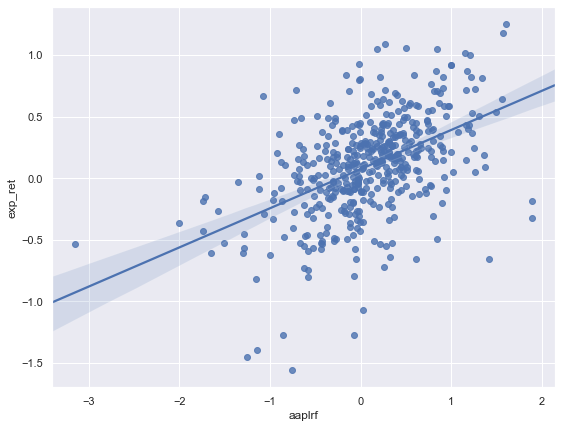

Average Expected Return in Excess of Market:  0.10%
Max Expected Return (Daily):  13.95%
Min Expected Return (Daily): -27.87%


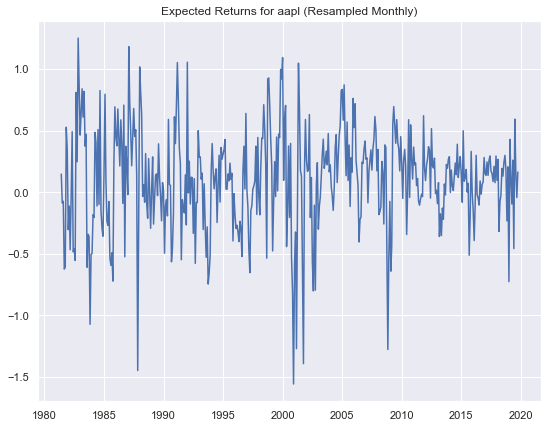

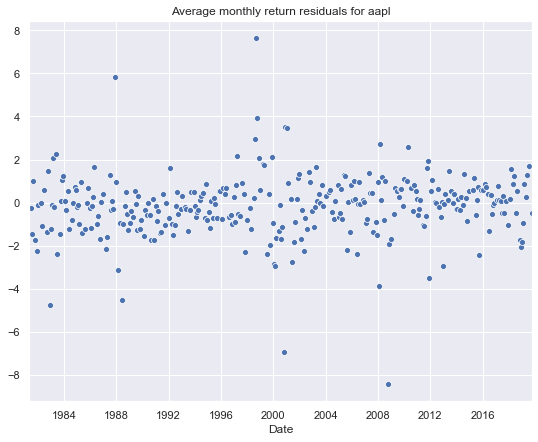

Average r_squared value: 0.26126134362777476
Max r_squared value: 0.7460372320020812
Min r_squared value: 0.00010342091869586234


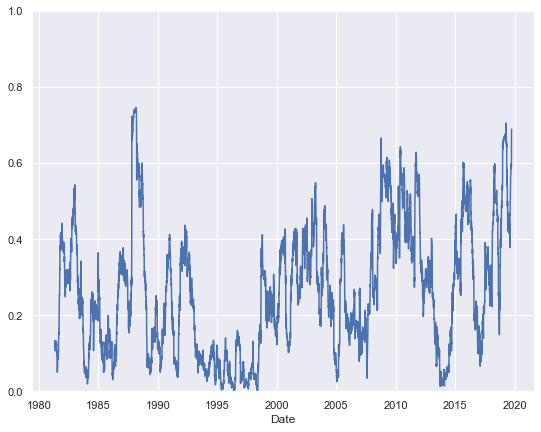

In [213]:
generate_four_plot_summary(AAPL_CAPM_results)

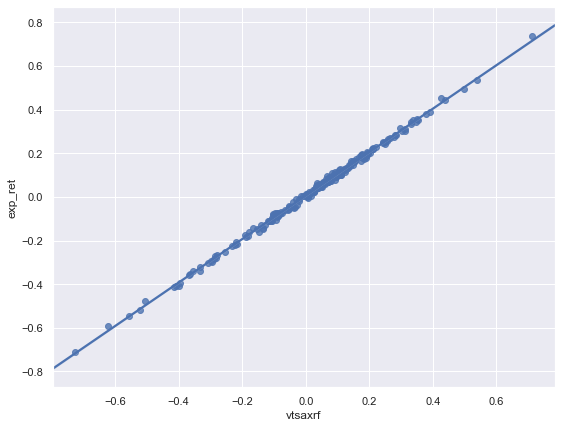

Average Expected Return in Excess of Market:  0.04%
Max Expected Return (Daily):  11.56%
Min Expected Return (Daily): -9.16%


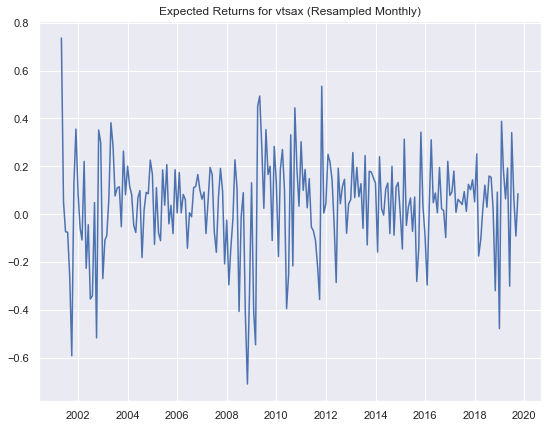

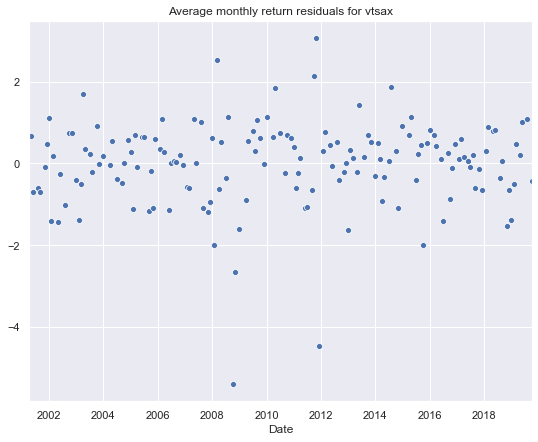

Average r_squared value: 0.9970786979836523
Max r_squared value: 0.999794229249449
Min r_squared value: 0.9104252553610817


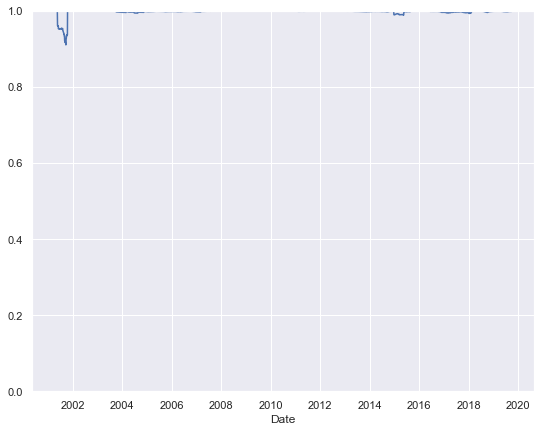

In [214]:
generate_four_plot_summary(VTSAX_CAPM_results)

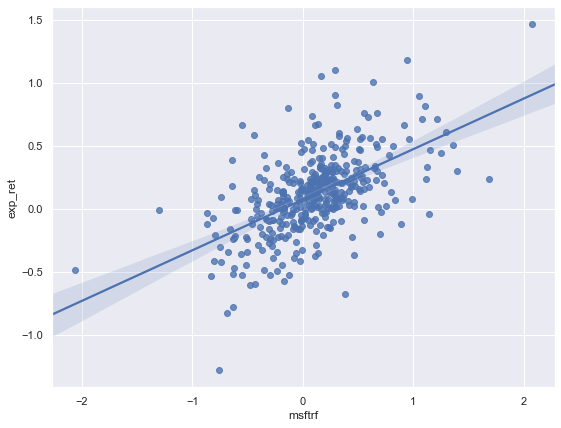

Average Expected Return in Excess of Market:  0.11%
Max Expected Return (Daily):  14.75%
Min Expected Return (Daily): -26.12%


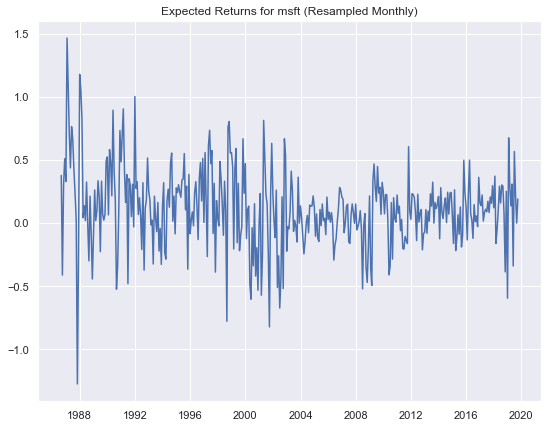

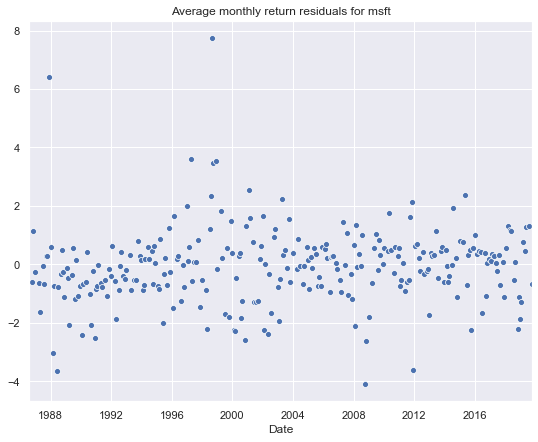

Average r_squared value: 0.3848143352790271
Max r_squared value: 0.810869692112631
Min r_squared value: 0.041464798723578444


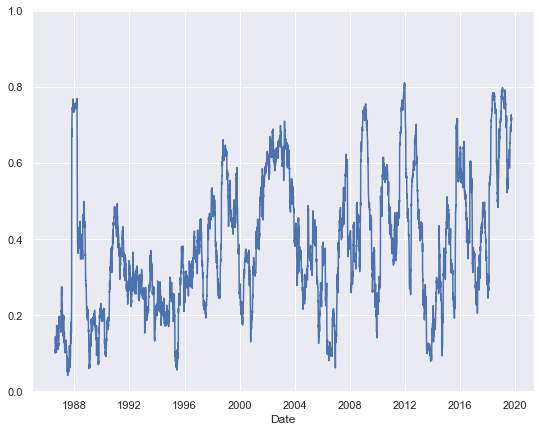

In [215]:
generate_four_plot_summary(MSFT_CAPM_results)

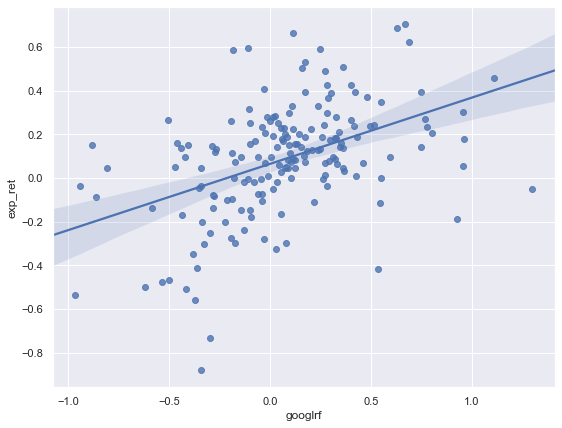

Average Expected Return in Excess of Market:  0.09%
Max Expected Return (Daily):  11.01%
Min Expected Return (Daily): -9.29%


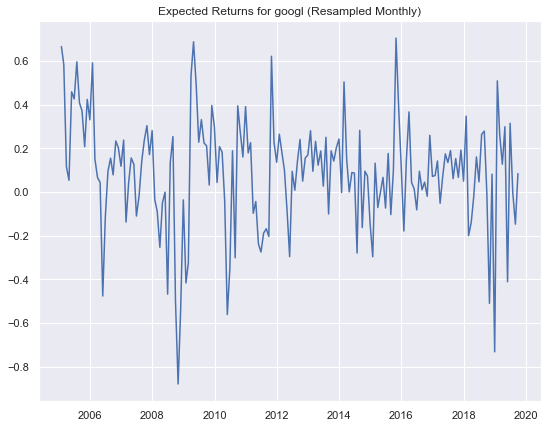

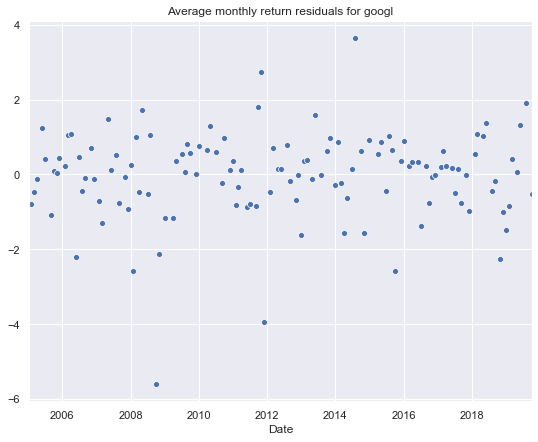

Average r_squared value: 0.36662271475647956
Max r_squared value: 0.7553126231260129
Min r_squared value: 1.8340343255207614e-07


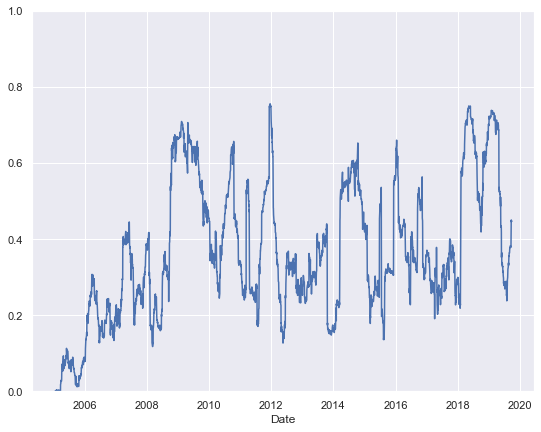

In [216]:
generate_four_plot_summary(GOOGL_CAPM_results)

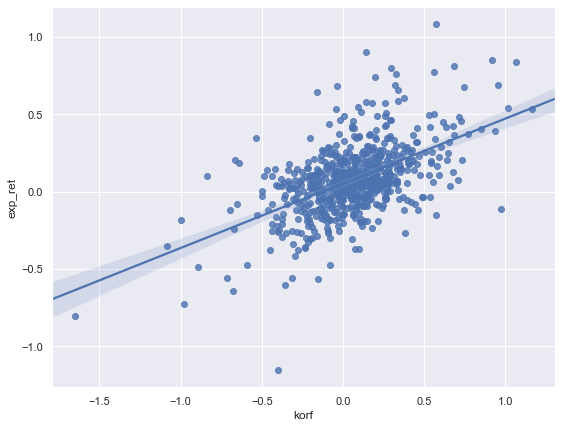

Average Expected Return in Excess of Market:  0.08%
Max Expected Return (Daily):  13.01%
Min Expected Return (Daily): -24.44%


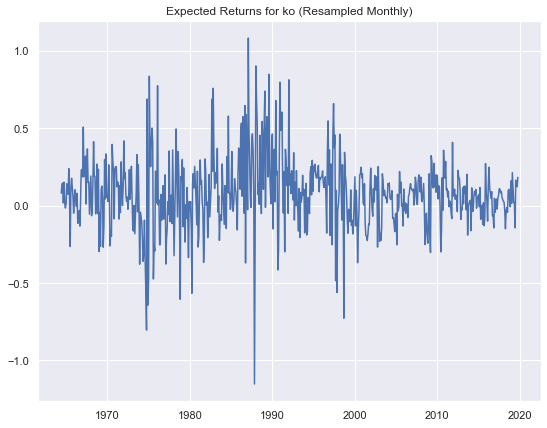

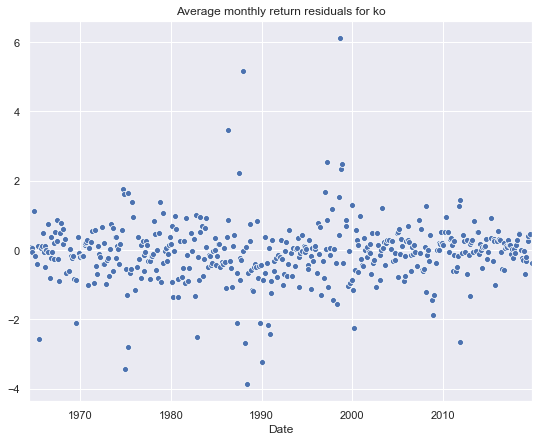

Average r_squared value: 0.27770096259125054
Max r_squared value: 0.7309928965775099
Min r_squared value: 7.574478200211843e-08


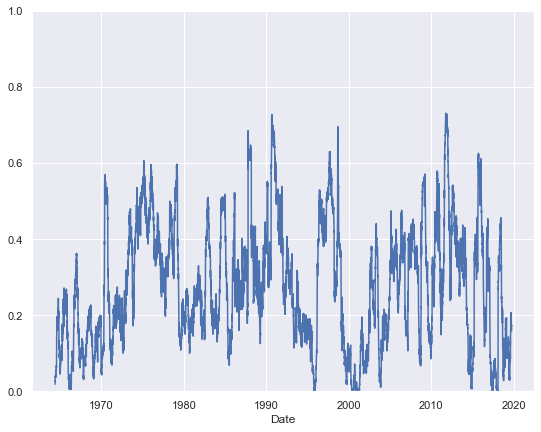

In [217]:
generate_four_plot_summary(KO_CAPM_results)

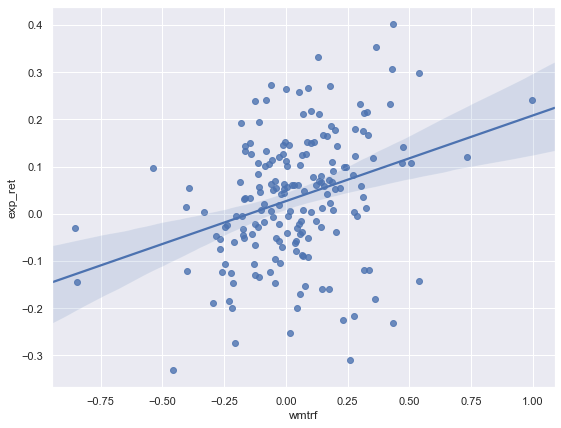

Average Expected Return in Excess of Market:  0.03%
Max Expected Return (Daily):  7.66%
Min Expected Return (Daily): -5.60%


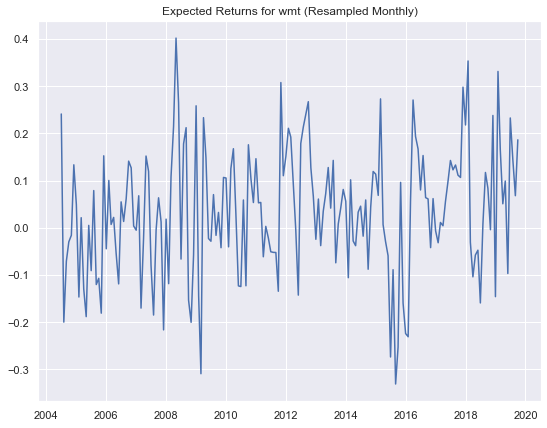

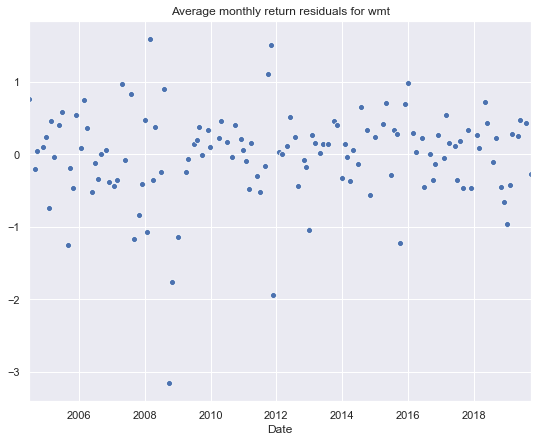

Average r_squared value: 0.24452728518438357
Max r_squared value: 0.6793121047025286
Min r_squared value: 0.004984849474096498


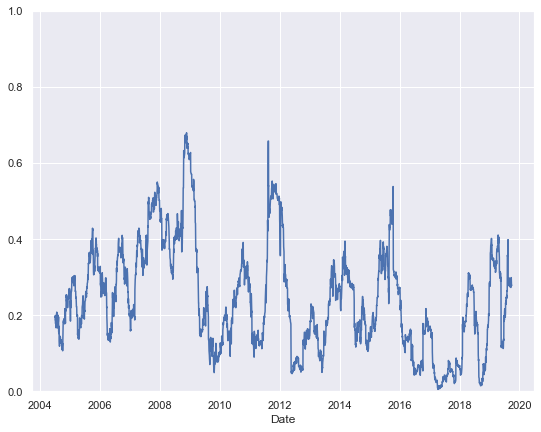

In [218]:
generate_four_plot_summary(WMT_CAPM_results)

## Fama French

### What is Fama French?

Fama French is an asset pricing model introduced by Eugene Fama and Kenneth French that attempts to improve upon CAPM by introducing a size factor and a value factor.

For the size factor, Fama French uses SMB (Small Minus Big), which favors smaller market cap stocks over large cap stocks

For the value factor, Fama French uses HML (High Minus Low), which favors stocks with a high book-to-market ratio (value stocks) over stocks with a low book-to-market ratio

The equation for calculating expected returns using Fama French is:

$E_r = R_f + \beta_1(R_m - R_f) + \beta_2(SMB) + \beta_3(HML) + \alpha$

$E_r$, $R_f$, $\beta_1$, and $R_m$ all correspond to the values that they take in the CAPM formula. This is logical as Fama French represents an extension on the CAPM formula.

$\beta_2$ is the coefficient for SMB that is extracted from a multivariate linear regression including $(R_m - R_f)$, SMB, and HML as explanatory variables

$\beta_3$ is the coefficient for HML that is extracted from a multivariate linear regression including $(R_m - R_f)$, SMB, and HML as explanatory variables

$\alpha$ is the intercept extracted from the multivariate linear regression

### Functions

In [158]:
def calculate_FF(beta_mkt, beta_SMB, beta_HML, alpha, RF, MktRF, SMB, HML):
    '''Function that takes in the parameters for Fama French and returns the expected return based on the Fama French formula'''
    expected_return = RF + (beta_mkt * MktRF) + (beta_SMB * SMB) + (beta_HML * HML) + alpha
    return expected_return

In [160]:
def generate_FF_results(ticker: str):
    '''
    Generates a dataframe containing complete FF information for the given stock
    - Dataframe columns include: stock returns - rf, market returns - rf, rf, SMB, HML CAPM regression objects, Beta for Mkt, Beta for SMB, Beta for HML, Alpha, and CAPM expected returns
    '''
    FF_results = pd.DataFrame(index=market[f'{ticker}rf'].dropna().index)
    FF_results[[f'{ticker}rf', 'MktRF', 'RF', 'SMB', 'HML']] = market[[f'{ticker}rf', 'MktRF', 'RF', 'SMB', 'HML']]
    FF_results['reg'] = roll_apply_OLS(df=FF_results, formula=f'{ticker}rf ~ MktRF + SMB + HML', window=100)
    FF_results['Beta_mkt'] = FF_results['reg'].dropna().apply(lambda reg: reg.fit().params[1])
    FF_results['Beta_SMB'] = FF_results['reg'].dropna().apply(lambda reg: reg.fit().params[2])
    FF_results['Beta_HML'] = FF_results['reg'].dropna().apply(lambda reg: reg.fit().params[3])
    FF_results['Alpha'] = FF_results['reg'].dropna().apply(lambda reg: reg.fit().params[0])
    FF_results['exp_ret'] = FF_results.apply(lambda row: calculate_FF(row["Beta_mkt"], row['Beta_SMB'], row['Beta_HML'], row['Alpha'], row['RF'], row['MktRF'], row['SMB'], row['HML']), axis=1)
    return FF_results

### FF Results

In [165]:
AAPL_FF_results = generate_FF_results('aapl')

In [166]:
VTSAX_FF_results = generate_FF_results('vtsax')

In [167]:
MSFT_FF_results = generate_FF_results('msft')

In [161]:
GOOGL_FF_results = generate_FF_results('googl')

In [169]:
KO_FF_results = generate_FF_results('ko')

In [170]:
WMT_FF_results = generate_FF_results('wmt')

#### Visualization

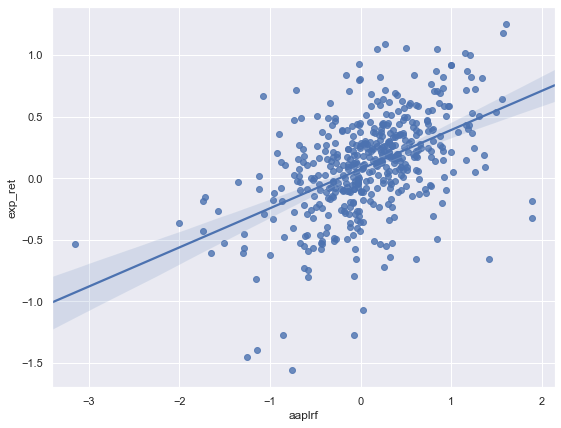

Average Expected Return in Excess of Market:  0.10%
Max Expected Return (Daily):  13.95%
Min Expected Return (Daily): -27.87%


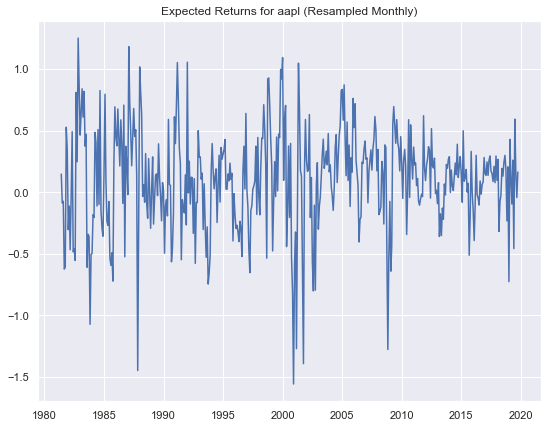

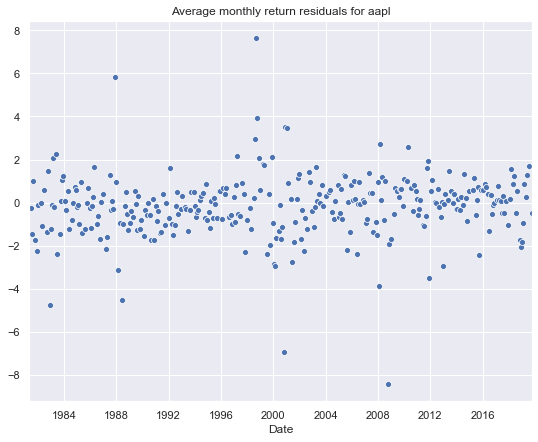

Average r_squared value: 0.26126134362777476
Max r_squared value: 0.7460372320020812
Min r_squared value: 0.00010342091869586234


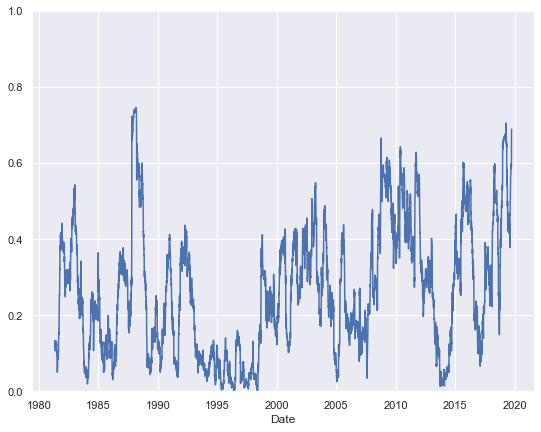

In [242]:
generate_four_plot_summary(AAPL_CAPM_results)

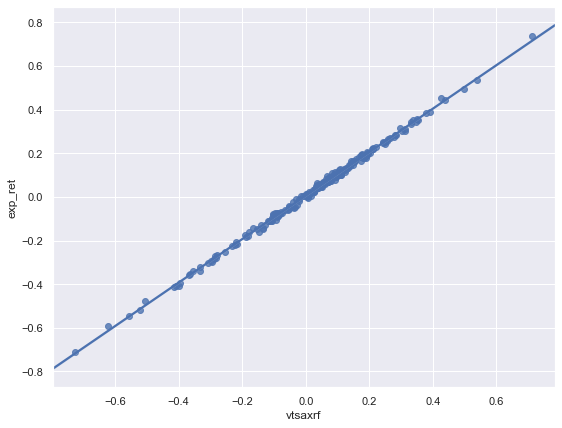

Average Expected Return in Excess of Market:  0.04%
Max Expected Return (Daily):  11.56%
Min Expected Return (Daily): -9.16%


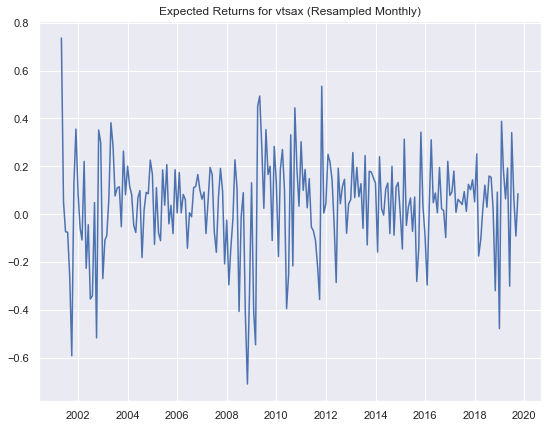

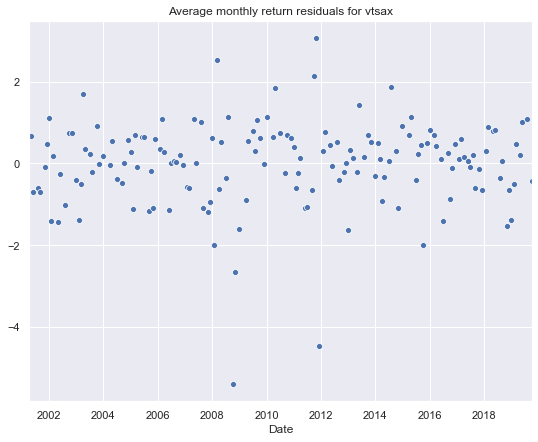

Average r_squared value: 0.9970786979836523
Max r_squared value: 0.999794229249449
Min r_squared value: 0.9104252553610817


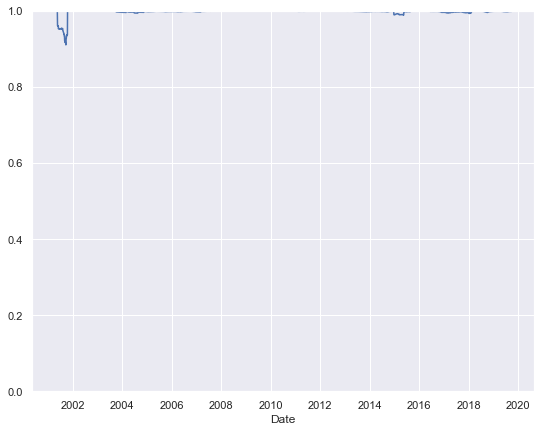

In [243]:
generate_four_plot_summary(VTSAX_CAPM_results)

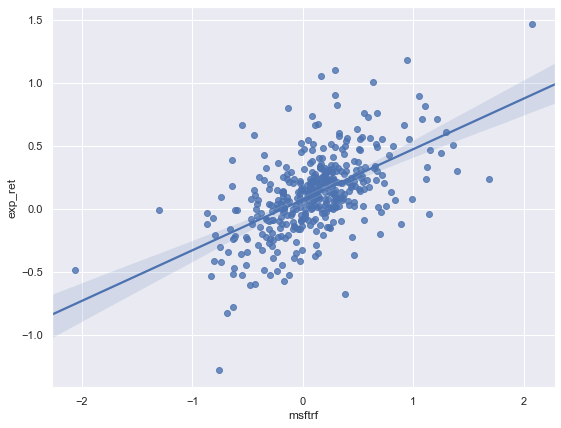

Average Expected Return in Excess of Market:  0.11%
Max Expected Return (Daily):  14.75%
Min Expected Return (Daily): -26.12%


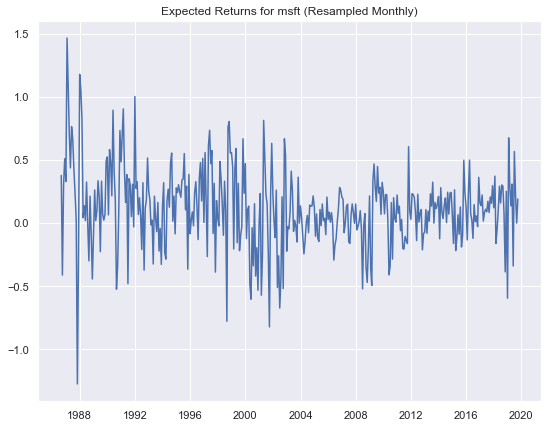

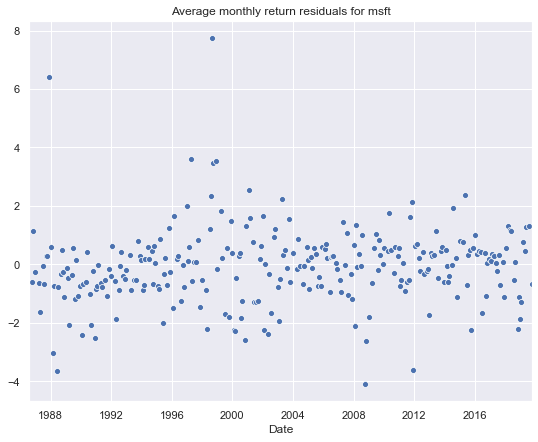

Average r_squared value: 0.3848143352790271
Max r_squared value: 0.810869692112631
Min r_squared value: 0.041464798723578444


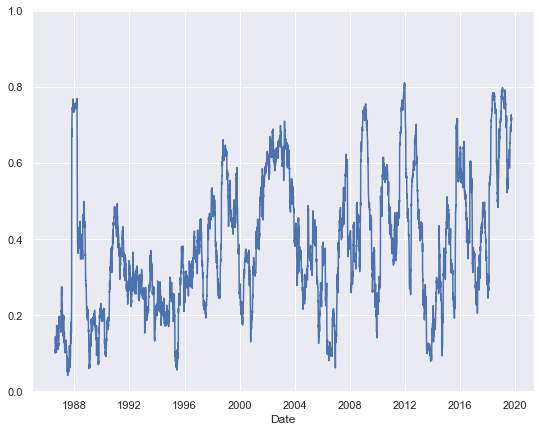

In [244]:
generate_four_plot_summary(MSFT_CAPM_results)

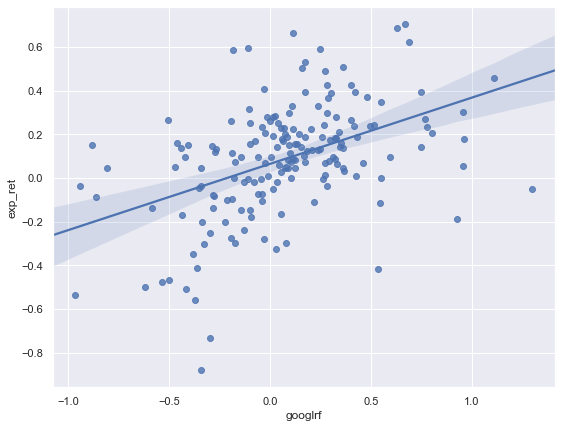

Average Expected Return in Excess of Market:  0.09%
Max Expected Return (Daily):  11.01%
Min Expected Return (Daily): -9.29%


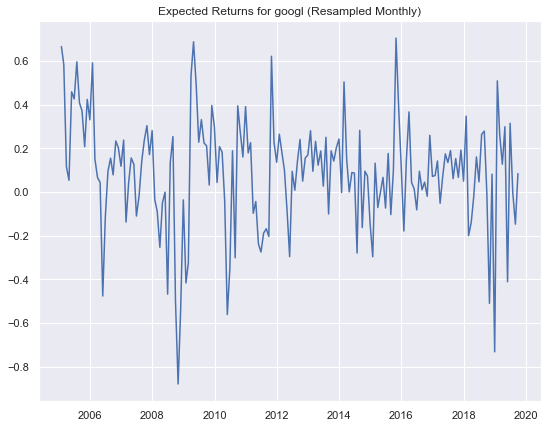

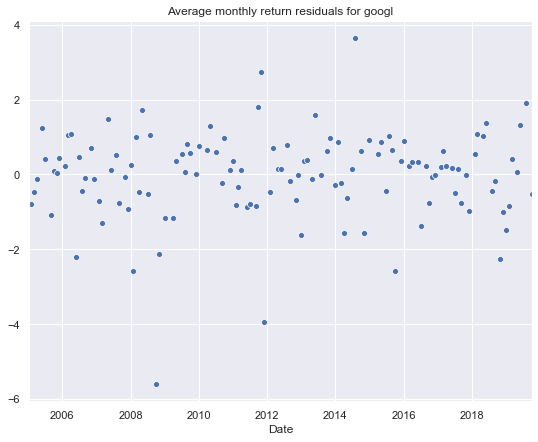

Average r_squared value: 0.36662271475647956
Max r_squared value: 0.7553126231260129
Min r_squared value: 1.8340343255207614e-07


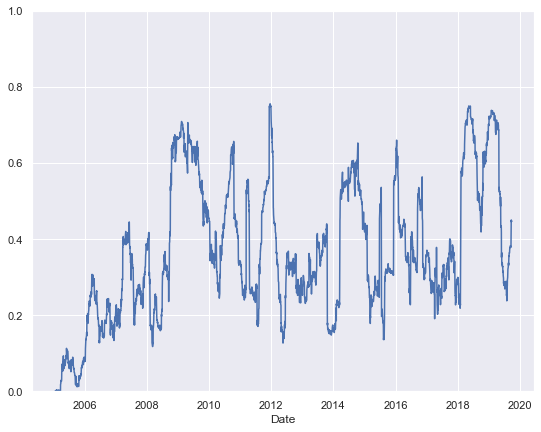

In [245]:
generate_four_plot_summary(GOOGL_CAPM_results)

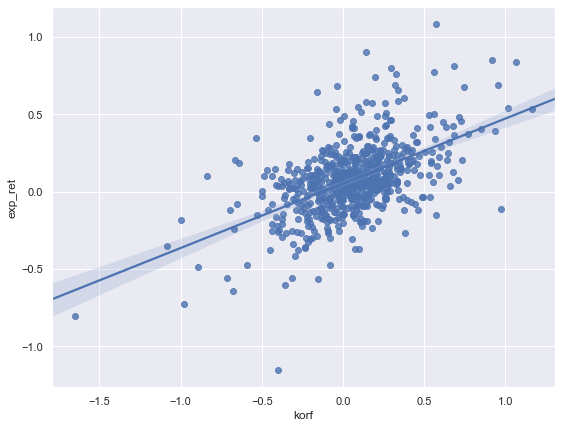

Average Expected Return in Excess of Market:  0.08%
Max Expected Return (Daily):  13.01%
Min Expected Return (Daily): -24.44%


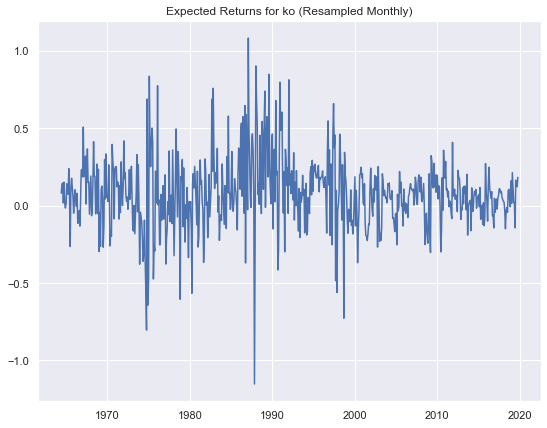

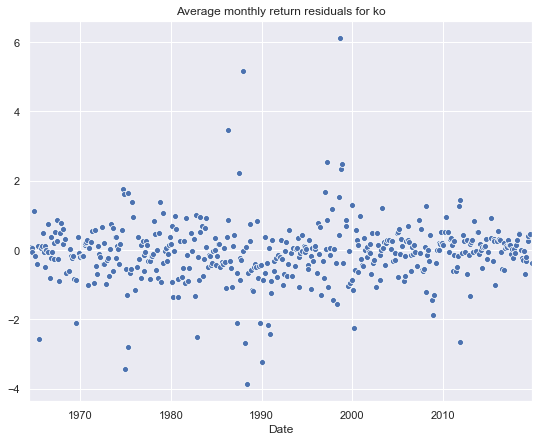

Average r_squared value: 0.27770096259125054
Max r_squared value: 0.7309928965775099
Min r_squared value: 7.574478200211843e-08


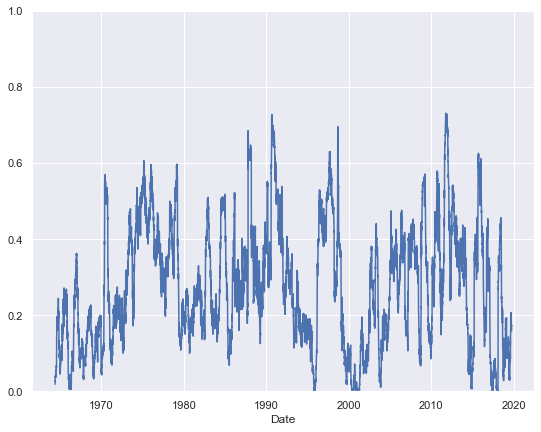

In [246]:
generate_four_plot_summary(KO_CAPM_results)

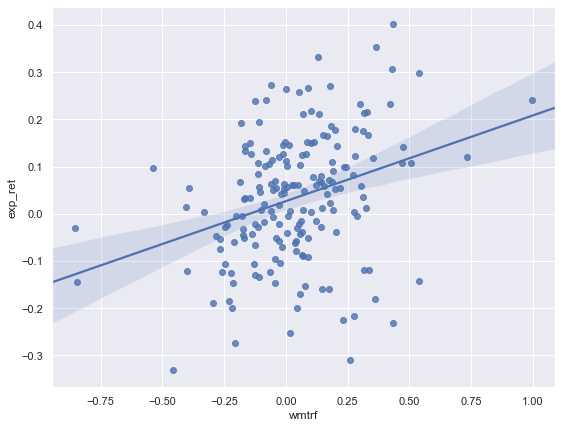

Average Expected Return in Excess of Market:  0.03%
Max Expected Return (Daily):  7.66%
Min Expected Return (Daily): -5.60%


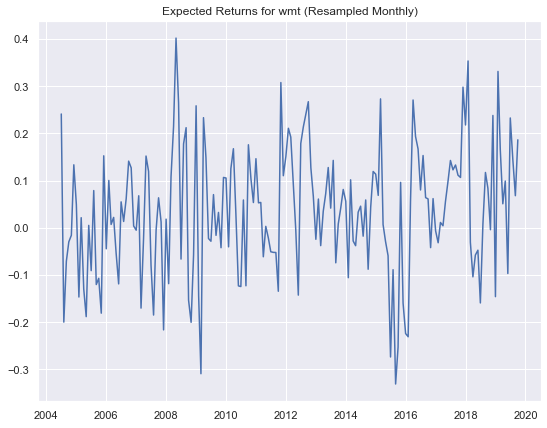

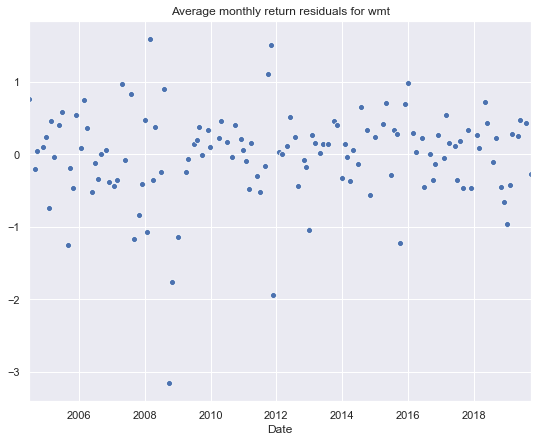

Average r_squared value: 0.24452728518438357
Max r_squared value: 0.6793121047025286
Min r_squared value: 0.004984849474096498


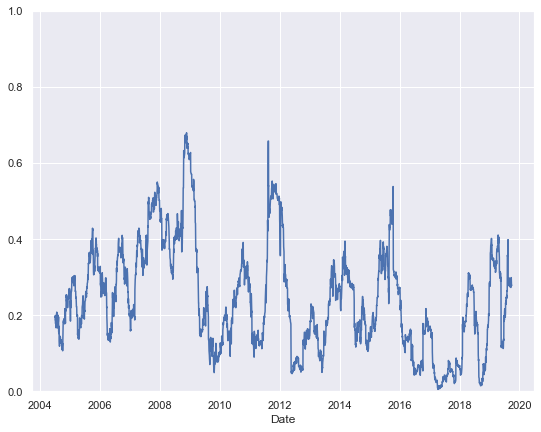

In [247]:
generate_four_plot_summary(WMT_CAPM_results)

In [301]:
# Save the data from the CAPM and Fama French calculations

In [299]:
# %pip install dill

In [178]:
# import dill

In [179]:
# Do dill.load_session('elliott_nb_env.db') to get the notebook state back again
# dill.dump_session('elliott_nb_env.db')

### Fama French vs. CAPM

Now that we've examined each model by itself, let's take a look at how they compare

### Functions

In [59]:
def plot_FF_vs_actual(FF_predictions: pd.Series, ticker: str, freq: str):
    fig, ax = plt.subplots()
#     ax.set_ylim(-.5, .5)
    plt.title(f'Predicted {freq} returns from Fama French vs Actual Returns: {ticker[:-2].upper()}')
    plt.plot(FF_predictions.resample(freq).mean(), label=f'Predicted {ticker[:-2].upper()} returns from Fama French')
    market_for_stock_dates = market[pd.notnull(market[ticker])]
    plt.plot(market_for_stock_dates[ticker].resample(freq).mean(), label=f'Actual {ticker[:-2].upper()} returns')
    plt.legend(loc='upper left')
    plt.show()

In [182]:
def generate_comparison_plot(CAPM_predictions: pd.Series, FF_predictions: pd.Series, ticker: str, freq: str):
    fig, ax = plt.subplots()
    plt.title(f'Predicted {freq} returns from CAPM and Fama French vs Actual Returns: {ticker[:-2].upper()}')
    plt.plot(CAPM_predictions.resample(freq).mean(), label=f'Predicted {ticker[:-2].upper()} returns from CAPM')
    plt.plot(FF_predictions.resample(freq).mean(), label=f'Predicted {ticker[:-2].upper()} returns from Fama French')
    market_for_stock_dates = market[pd.notnull(market[ticker])]
    plt.plot(market_for_stock_dates[ticker][100:].resample(freq).mean(), label=f'Actual {ticker[:-2].upper()} returns')
    plt.legend(loc='upper left')
    plt.show()

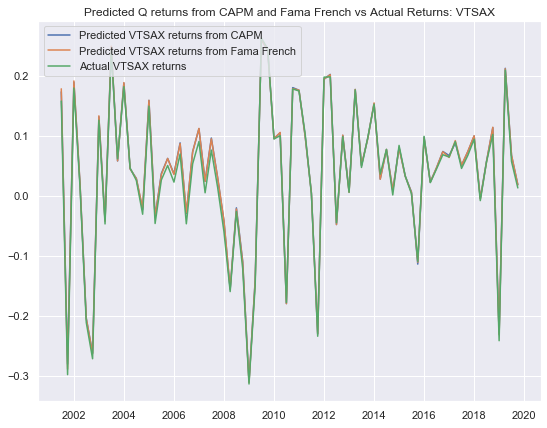

In [219]:
generate_comparison_plot(VTSAX_CAPM_results['exp_ret'], VTSAX_FF_results['exp_ret'], 'vtsaxrf', 'Q')

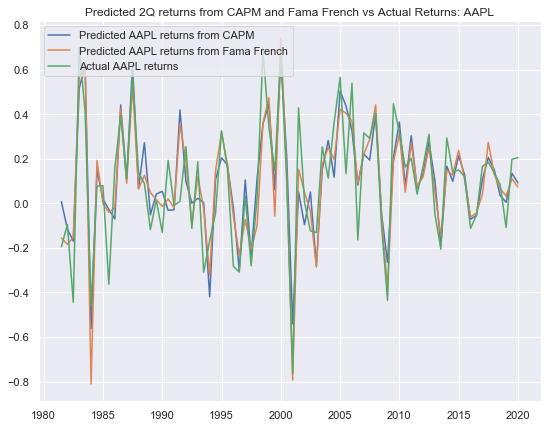

In [220]:
generate_comparison_plot(AAPL_CAPM_results['exp_ret'], AAPL_FF_results['exp_ret'], 'aaplrf', '2Q')

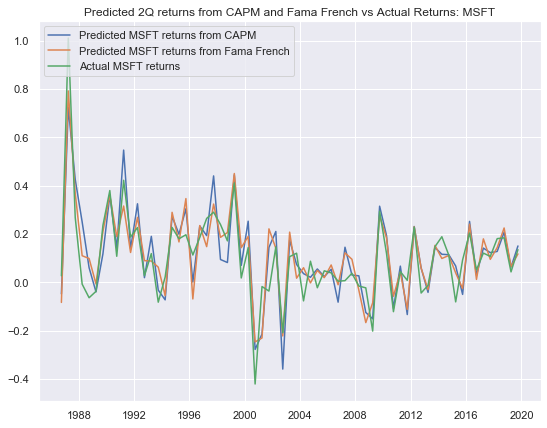

In [221]:
generate_comparison_plot(MSFT_CAPM_results['exp_ret'], MSFT_FF_results['exp_ret'], 'msftrf', '2Q')

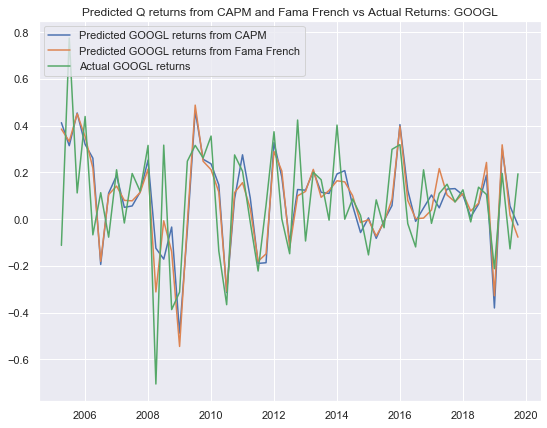

In [222]:
generate_comparison_plot(GOOGL_CAPM_results['exp_ret'], GOOGL_FF_results['exp_ret'], 'googlrf', 'Q')

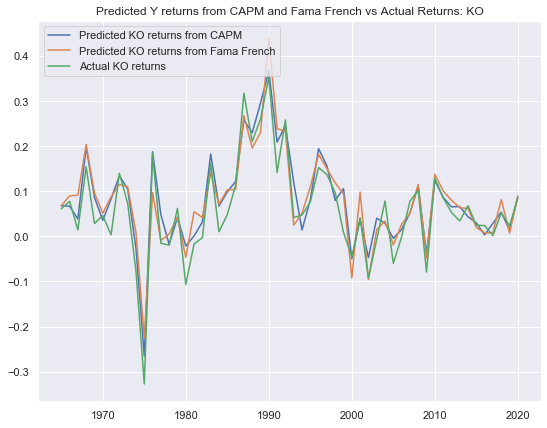

In [223]:
generate_comparison_plot(KO_CAPM_results['exp_ret'], KO_FF_results['exp_ret'], 'korf', 'Y')

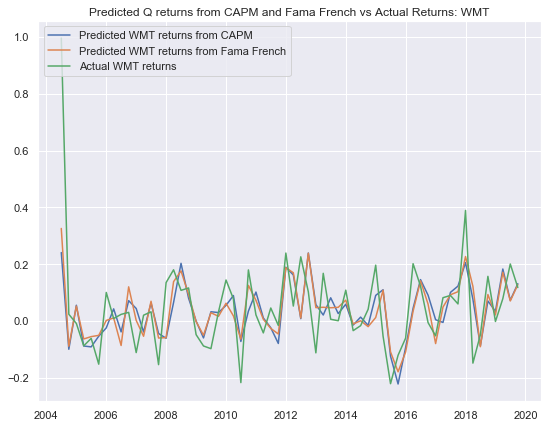

In [224]:
generate_comparison_plot(WMT_CAPM_results['exp_ret'], WMT_FF_results['exp_ret'], 'wmtrf', 'Q')

### Create our super basic portfolio

-Equal weighted portfolio containing the five stocks we happened to take in data for

-Includes AAPL, GOOGL, MSFT, KO, and WMT

-Overrepresents technology sector

-Could use a bit more diversification

In [225]:
portfolio = pd.DataFrame()
portfolio[['aaplrf', 'googlrf', 'mstfrf', 'korf', 'wmtrf']] = market[['aaplrf', 'googlrf', 'msftrf', 'korf', 'wmtrf']]
portfolio = portfolio[pd.notnull(portfolio['googlrf'])]
# Assume same weights for each stock, so we just take average of row to get portfolio returns
portfolio['returns'] = portfolio.apply(lambda row: np.mean(row), axis=1)
portfolio.head()
market['portrf'] = portfolio['returns']

In [227]:
Portfolio_CAPM_results = generate_CAPM_results('port')
Portfolio_FF_results = generate_FF_results('port')

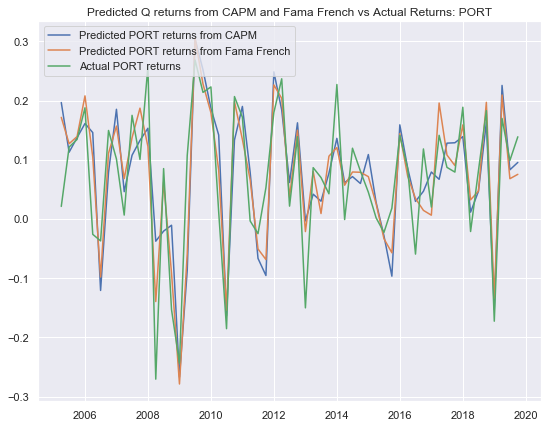

In [300]:
generate_comparison_plot(Portfolio_CAPM_results['exp_ret'], Portfolio_FF_results['exp_ret'], 'portrf', 'Q')

In [236]:
print(portfolio['returns'][100:].tail())
Portfolio_CAPM_results['exp_ret'][100:].tail()

Date
2019-09-24   -0.430351
2019-09-25    1.004228
2019-09-26   -0.092383
2019-09-27   -0.632866
2019-09-30    0.658720
Name: returns, dtype: float64


Date
2019-09-24   -0.918328
2019-09-25    0.780627
2019-09-26   -0.306753
2019-09-27   -0.510245
2019-09-30    0.594860
Name: exp_ret, dtype: float64

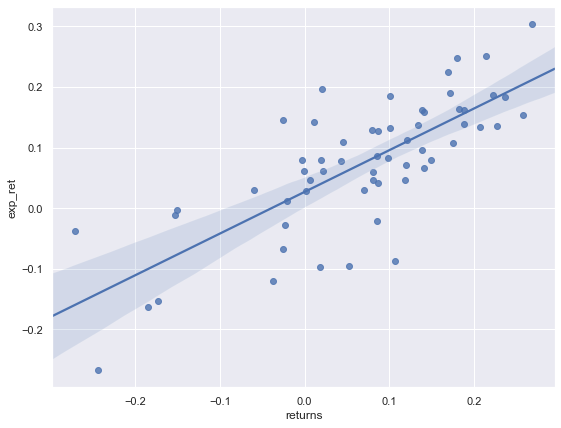

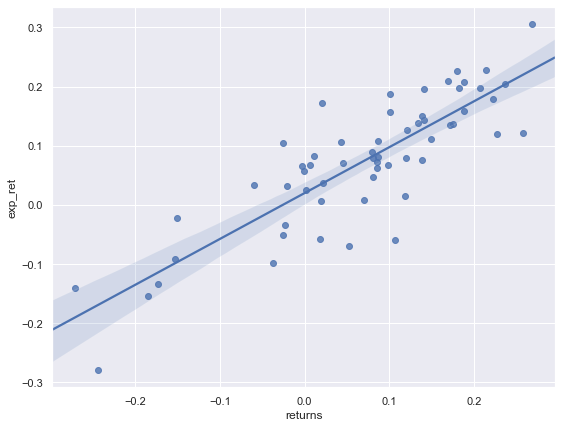

In [237]:
seaborn.regplot(x=portfolio['returns'][100:].resample('Q').mean(), y=Portfolio_CAPM_results['exp_ret'].dropna().resample('Q').mean())
plt.show()

seaborn.regplot(x=portfolio['returns'][100:].resample('Q').mean(), y=Portfolio_FF_results['exp_ret'].dropna().resample('Q').mean())
plt.show()

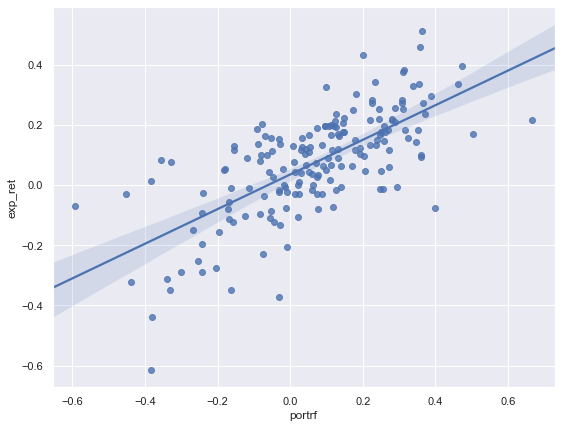

Average Expected Return in Excess of Market:  0.07%
Max Expected Return (Daily):  9.51%
Min Expected Return (Daily): -8.04%


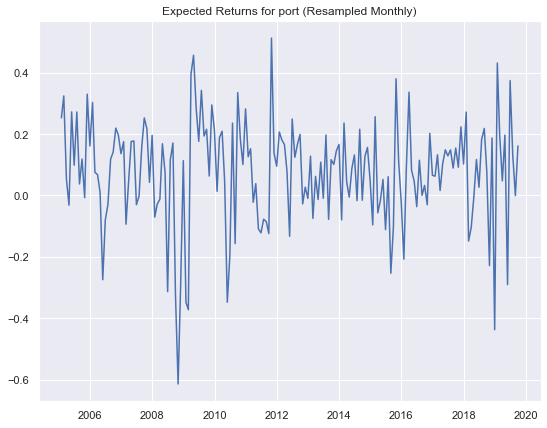

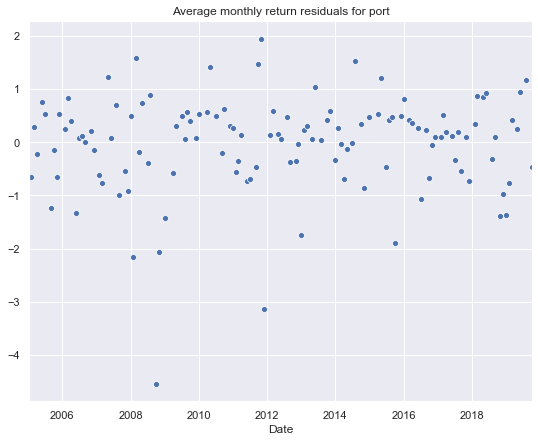

Average r_squared value: 0.6295152415286774
Max r_squared value: 0.901705795220991
Min r_squared value: 0.17082153006027834


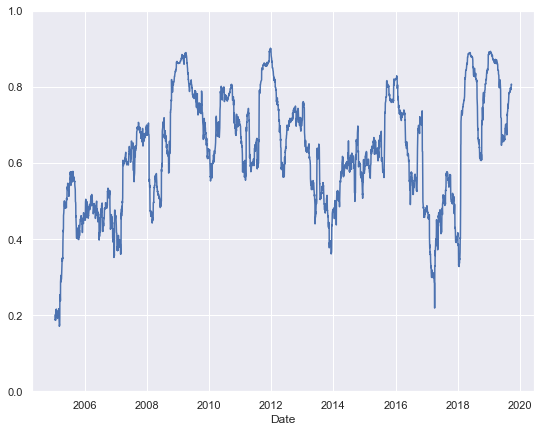

In [239]:
generate_four_plot_summary(Portfolio_CAPM_results)

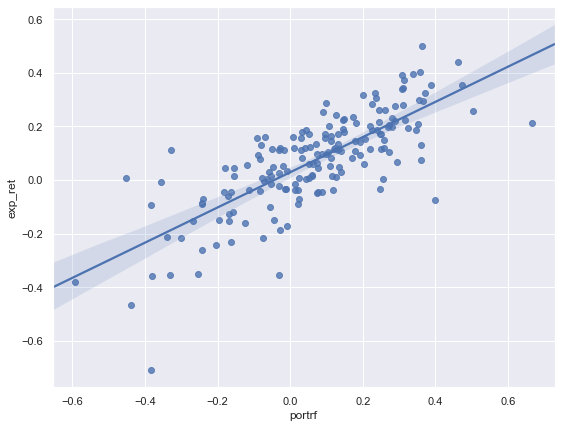

Average Expected Return in Excess of Market:  0.07%
Max Expected Return (Daily):  10.42%
Min Expected Return (Daily): -9.20%


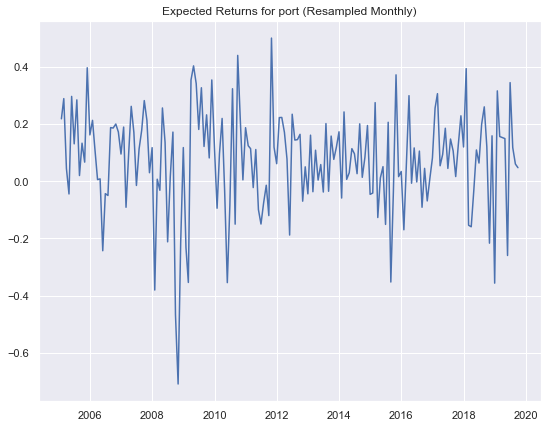

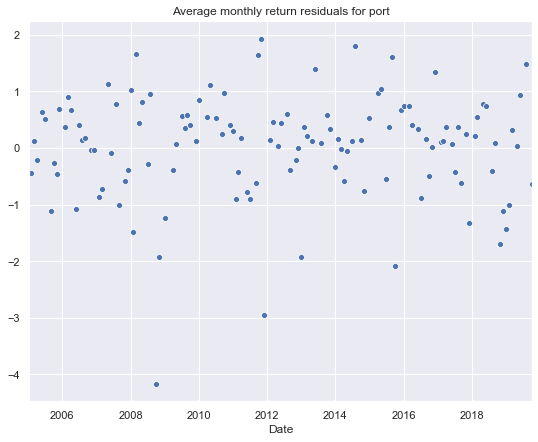

Average r_squared value: 0.6962919833710814
Max r_squared value: 0.9332403529350302
Min r_squared value: 0.21203842654637717


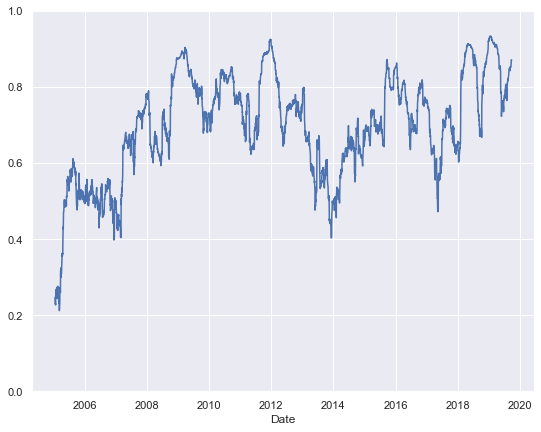

In [238]:
generate_four_plot_summary(Portfolio_FF_results)

In [241]:
print(portfolio['returns'][100:].head())
print(Portfolio_CAPM_results['exp_ret'].dropna().head())
print(Portfolio_FF_results['exp_ret'].dropna().head())

Date
2005-01-12    0.681232
2005-01-13    0.565212
2005-01-14    0.710916
2005-01-18    0.988278
2005-01-19   -1.465010
Name: returns, dtype: float64
Date
2005-01-12    0.500753
2005-01-13   -0.261028
2005-01-14    0.668854
2005-01-18    0.872961
2005-01-19   -0.357431
Name: exp_ret, dtype: float64
Date
2005-01-12    0.574303
2005-01-13   -0.395667
2005-01-14    0.543968
2005-01-18    0.866808
2005-01-19   -0.492702
Name: exp_ret, dtype: float64


# Introducing our own model?

### Adding in UMD and QMJ

In [248]:
AQR_dat = pd.read_csv('AQR_UMD_and_QMJ_Factors_2001_to_present.csv')
AQR_dat['Date'] = pd.to_datetime(AQR_dat['Date'])
AQR_dat.set_index('Date', inplace=True)
AQR_dat['UMD'] = AQR_dat['UMD'].str.strip('%').astype(float)
AQR_dat['QMJ'] = AQR_dat['QMJ'].str.strip('%').astype(float)
AQR_dat.head()


,UMD,QMJ
Date,,
2001-03-31,8.50,4.62
2001-04-30,-8.05,-1.97
2001-05-31,2.09,-1.41
2001-06-30,2.00,2.03
2001-07-31,5.70,4.68


In [265]:
market[['UMD', 'QMJ']] = AQR_dat[['UMD', 'QMJ']]
market_UMD_dates_only = market[pd.notnull(market['UMD'])]
market_portfolio_dates_only = market_UMD_dates_only[pd.notnull(market_UMD_dates_only['portrf'])]
market_portfolio_dates_only.head()

,Adj Close,ret,vtsax,aapl,msft,googl,ko,wmt,MktRF,RF,...,HML,vtsaxrf,aaplrf,msftrf,googlrf,korf,wmtrf,portrf,UMD,QMJ
Date,,,,,,,,,,,,,,,,,,,,,
2004-08-31,1104.239990,0.463082,0.504618,1.084431,0.000000,0.352906,0.811774,-0.996262,0.48,0.005,...,0.15,0.499618,1.079431,-0.005000,0.347906,0.806774,-1.001262,0.245570,-1.48,-0.05
2004-09-30,1114.579956,-0.019743,0.076222,0.180951,0.253777,-1.129077,0.099999,0.377377,0.06,0.005,...,0.52,0.071222,0.175951,0.248777,-1.134077,0.094999,0.372377,-0.048395,4.57,-1.13
2004-11-30,1173.819946,-0.403031,-0.356478,-2.030985,0.149376,0.513666,-1.007241,-2.050797,-0.37,0.007,...,0.11,-0.363478,-2.037985,0.142376,0.506666,-1.014241,-2.057797,-0.892196,2.87,-2.01
2004-12-31,1211.920044,-0.134317,-0.138819,-0.617308,-0.149448,-2.434205,-0.024049,-0.452343,-0.14,0.007,...,0.20,-0.145819,-0.624308,-0.156448,-2.441205,-0.031049,-0.459343,-0.742470,-2.62,-0.92
2005-01-31,1181.270020,0.846028,0.973646,3.947008,0.381975,2.773981,0.000000,-0.057215,0.97,0.008,...,0.16,0.965646,3.939008,0.373975,2.765981,-0.008000,-0.065215,1.401150,3.00,1.89


Average r_squared value: 0.7095073626338309
Max r_squared value: 0.8347204506142009
Min r_squared value: 0.4858966657092616


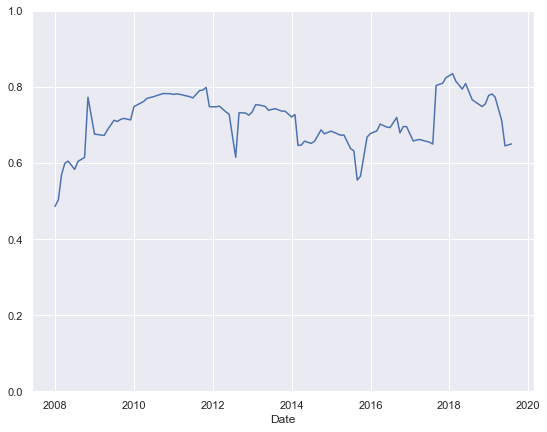

In [297]:
CAPM_regression_monthly = roll_apply_OLS(df=market_portfolio_dates_only, formula='portrf ~ MktRF', window=30)
plot_r_squared(CAPM_regression_monthly.dropna())

In [298]:
CAPM_regression_monthly[-1].fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 portrf   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     57.29
Date:                Fri, 22 Nov 2019   Prob (F-statistic):           3.03e-08
Time:                        02:22:29   Log-Likelihood:                -15.682
No. Observations:                  30   AIC:                             35.36
Df Residuals:                      28   BIC:                             38.17
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0398      0.077     -0.514      0.611      -0.198       0.119
MktRF          0.8641      0.114      7.569      0.000       0.630       1.098
==============================================================================
Omnibus:                       13.287   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               13.943
Skew:                          -1.223   Prob(JB):                     0.000938
Kurtosis:                       5.274   Cond. No.                         1.49
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Average r_squared value: 0.774628436057405
Max r_squared value: 0.896823135214747
Min r_squared value: 0.5716640667983846


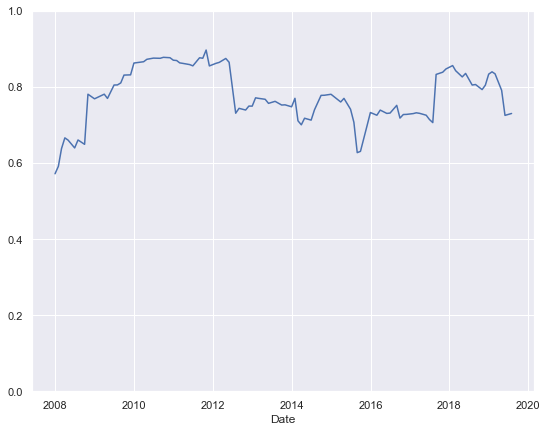

In [295]:
FF_regression_monthly = roll_apply_OLS(df=market_portfolio_dates_only, formula='portrf ~ MktRF + HML + SMB', window=30)
plot_r_squared(FF_regression_monthly.dropna())

In [296]:
FF_regression_monthly[-1].fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 portrf   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     26.11
Date:                Fri, 22 Nov 2019   Prob (F-statistic):           5.25e-08
Time:                        02:21:05   Log-Likelihood:                -11.550
No. Observations:                  30   AIC:                             31.10
Df Residuals:                      26   BIC:                             36.71
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0859      0.072     -1.195      0.243      -0.234       0.062
MktRF          0.7981      0.106      7.501      0.000       0.579       1.017
HML           -0.3515      0.122     -2.870      0.008      -0.603      -0.100
SMB           -0.0789      0.144     -0.549      0.588      -0.375       0.217
==============================================================================
Omnibus:                        5.376   Durbin-Watson:                   2.112
Prob(Omnibus):                  0.068   Jarque-Bera (JB):                3.669
Skew:                          -0.685   Prob(JB):                        0.160
Kurtosis:                       4.029   Cond. No.                         2.17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Average r_squared value: 0.7810825542986836
Max r_squared value: 0.9074346049232634
Min r_squared value: 0.5836625306960219


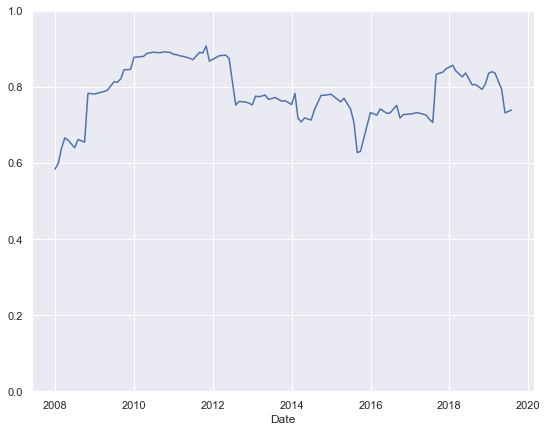

In [288]:
UMD_regressions = roll_apply_OLS(df=market_portfolio_dates_only, formula='portrf ~ MktRF + HML + SMB + UMD', window=30)
plot_r_squared(UMD_regressions.dropna())

In [289]:
UMD_regressions[-1].fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 portrf   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     20.61
Date:                Fri, 22 Nov 2019   Prob (F-statistic):           1.29e-07
Time:                        02:15:06   Log-Likelihood:                -10.520
No. Observations:                  30   AIC:                             31.04
Df Residuals:                      25   BIC:                             38.05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1058      0.072     -1.461      0.156      -0.255       0.043
MktRF          0.8358      0.109      7.696      0.000       0.612       1.059
HML           -0.3441      0.121     -2.849      0.009      -0.593      -0.095
SMB           -0.1152      0.144     -0.798      0.432      -0.412       0.182
UMD            0.0288      0.022      1.333      0.195      -0.016       0.073
==============================================================================
Omnibus:                        4.279   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.118   Jarque-Bera (JB):                2.676
Skew:                          -0.589   Prob(JB):                        0.262
Kurtosis:                       3.869   Cond. No.                         7.36
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Average r_squared value: 0.7881188338738884
Max r_squared value: 0.9015694236013252
Min r_squared value: 0.5716900486849164


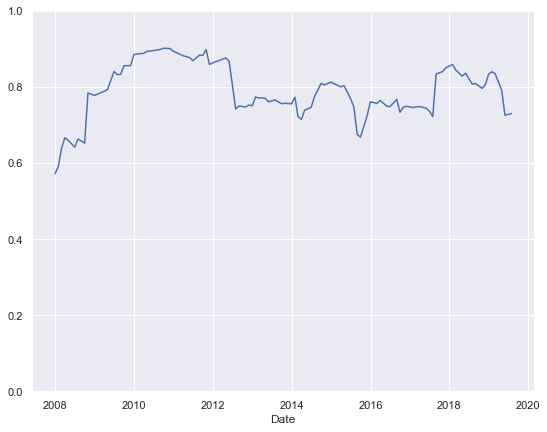

In [292]:
QMJ_regressions = roll_apply_OLS(df=market_portfolio_dates_only, formula='portrf ~ MktRF + HML + SMB + QMJ', window=30)
plot_r_squared(QMJ_regressions.dropna())

In [293]:
QMJ_regressions[-1].fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 portrf   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     18.86
Date:                Fri, 22 Nov 2019   Prob (F-statistic):           2.93e-07
Time:                        02:18:46   Log-Likelihood:                -11.530
No. Observations:                  30   AIC:                             33.06
Df Residuals:                      25   BIC:                             40.07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0826      0.075     -1.097      0.283      -0.238       0.073
MktRF          0.7998      0.109      7.349      0.000       0.576       1.024
HML           -0.3507      0.125     -2.808      0.010      -0.608      -0.093
SMB           -0.0881      0.155     -0.569      0.574      -0.407       0.231
QMJ           -0.0077      0.042     -0.184      0.856      -0.094       0.079
==============================================================================
Omnibus:                        5.164   Durbin-Watson:                   2.102
Prob(Omnibus):                  0.076   Jarque-Bera (JB):                3.461
Skew:                          -0.685   Prob(JB):                        0.177
Kurtosis:                       3.944   Cond. No.                         4.17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Average r_squared value: 0.7916331335138792
Max r_squared value: 0.9083794784712835
Min r_squared value: 0.5838997996822736


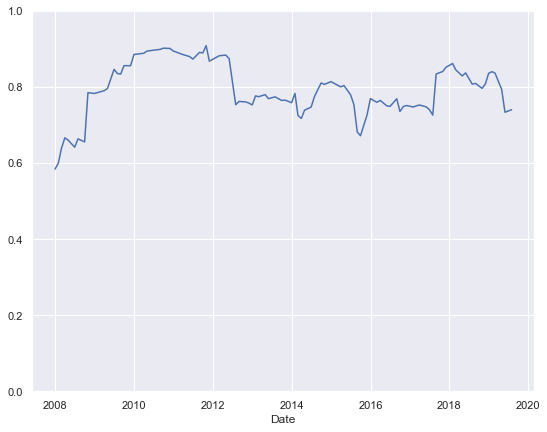

In [286]:
UMD_and_QMJ_regression = roll_apply_OLS(df=market_portfolio_dates_only, formula='portrf ~ MktRF + HML + SMB + QMJ + UMD', window=30)
plot_r_squared(UMD_and_QMJ_regression.dropna())

In [291]:
UMD_and_QMJ_regression[-1].fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 portrf   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     16.45
Date:                Fri, 22 Nov 2019   Prob (F-statistic):           4.51e-07
Time:                        02:15:28   Log-Likelihood:                -10.075
No. Observations:                  30   AIC:                             32.15
Df Residuals:                      24   BIC:                             40.56
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0957      0.074     -1.298      0.207      -0.248       0.056
MktRF          0.8559      0.112      7.660      0.000       0.625       1.087
HML           -0.3379      0.122     -2.776      0.010      -0.589      -0.087
SMB           -0.1723      0.160     -1.078      0.292      -0.502       0.158
QMJ           -0.0386      0.045     -0.851      0.403      -0.132       0.055
UMD            0.0377      0.024      1.564      0.131      -0.012       0.087
==============================================================================
Omnibus:                        2.647   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.266   Jarque-Bera (JB):                1.518
Skew:                          -0.521   Prob(JB):                        0.468
Kurtosis:                       3.357   Cond. No.                         8.31
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""